In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from tabulate import tabulate

pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
games_df = pd.read_csv('games.csv')
plays_df = pd.read_csv('plays.csv')
scout_df = pd.read_csv('pffScoutingData.csv')

In [3]:
# NOTE: uses 3.8GB of RAM
dfs = []
for i in range(1, 9):
    dfs.append(pd.read_csv(f'week{i}.csv'))
track_df = pd.concat(dfs, ignore_index=True)
del dfs

# Preprocessing

In [4]:
# Create gameId/playId tuples to use with indexing expressions for each DataFrame
track_gp_combos = track_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)
plays_gp_combos = plays_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)
scout_gp_combos = scout_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)

In [5]:
# Create a GroupBy for gameId/playId combinations for all sack plays
sacks_gp_gb = scout_df.loc[scout_df['pff_sack'] == 1].groupby(['gameId', 'playId'])

In [6]:
track_sacks_df = track_df.loc[track_gp_combos.isin(sacks_gp_gb.groups.keys())]
track_nonsacks_df = track_df.loc[~track_gp_combos.isin(sacks_gp_gb.groups.keys())]

In [7]:
# Group all pass rushers by gameId/playId/nflId
pass_rush_ids_gb = scout_df.loc[scout_df['pff_role'] == 'Pass Rush'].groupby(['gameId', 'playId', 'nflId'])

In [8]:
sacks_gpn_combos = track_sacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonsacks_gpn_combos = track_nonsacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

# Total distance
First compare the total distance of pass rushers between sack on non-sack plays.

In [9]:
# Get the total distance (yds) of all pass rushers for all sack and non-sack plays
sacks_sum_dist = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonsacks_sum_dist = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()

tbl = [['Total dist nonsacks', nonsacks_sum_dist],
       ['Total dist sacks', sacks_sum_dist]]
print(tabulate(tbl, tablefmt='grid', floatfmt='.2f'))

+---------------------+-----------+
| Total dist nonsacks | 331887.56 |
+---------------------+-----------+
| Total dist sacks    |  32523.84 |
+---------------------+-----------+


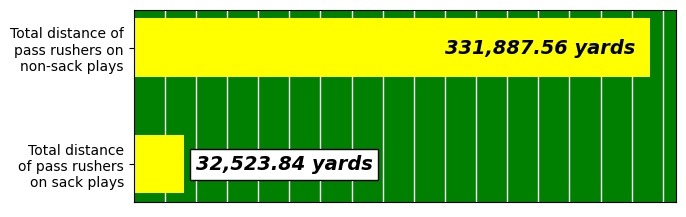

In [10]:
# Plot the values
fig, ax = plt.subplots(figsize=(7, 2.5))
plt.barh(y=[0, 1], width=[sacks_sum_dist, nonsacks_sum_dist], height=0.5, color=['yellow'])
ax.set_yticks([0, 1], labels=['Total distance\nof pass rushers\non sack plays',
                              'Total distance of\npass rushers on\nnon-sack plays'])
fd = {'fontstyle': 'italic', 'fontweight': 'bold', 'fontsize': 14}
plt.text(200000, 0.95, f'{round(nonsacks_sum_dist, 2):,} yards', fontdict=fd)
plt.text(40000, -0.05, f'{round(sacks_sum_dist, 2):,} yards', fontdict=fd,
         bbox={'facecolor': 'white'})
ax.set_facecolor('green')
ax.set_xticks([])
for i in range(20000, 360000, 20000):
    ax.axvline(i, color='white', lw=1, zorder=-1)
plt.show()

# Distance per play of pass rushers

In [11]:
# Get the total number of sack and non-sack plays
num_sack_plays = plays_df['passResult'].value_counts().loc[['S']].sum()
num_nonsack_plays = plays_df['passResult'].value_counts().loc[['C', 'I', 'IN', 'R']].sum()

tbl = [['Number of nonsack plays', num_nonsack_plays],
       ['Number of sack plays', num_sack_plays]]
print(tabulate(tbl, tablefmt='grid'))

+-------------------------+------+
| Number of nonsack plays | 8014 |
+-------------------------+------+
| Number of sack plays    |  543 |
+-------------------------+------+


In [12]:
sacks_dist_per_play = sacks_sum_dist/num_sack_plays
nonsacks_dist_per_play = nonsacks_sum_dist/num_nonsack_plays

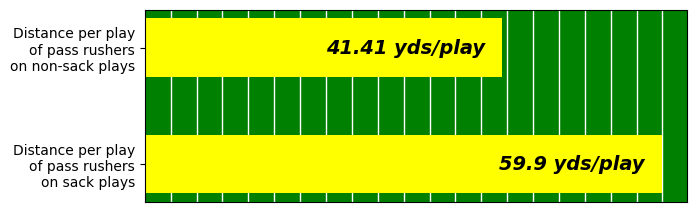

In [13]:
fig, ax = plt.subplots(figsize=(7, 2.5))
plt.barh(y=[0, 1], width=[sacks_dist_per_play, nonsacks_dist_per_play], height=0.5, color=['yellow'])
ax.set_yticks([0, 1], labels=['Distance per play\nof pass rushers\non sack plays',
                              'Distance per play\nof pass rushers\non non-sack plays'])
fd = {'fontstyle': 'italic', 'fontweight': 'bold', 'fontsize': 14}
plt.text(21, 0.95, f'{round(nonsacks_dist_per_play, 2):,} yds/play', fontdict=fd)
plt.text(41, -0.05, f'{round(sacks_dist_per_play, 2):,} yds/play', fontdict=fd)
ax.set_facecolor('green')
ax.set_xticks([])
for i in range(3, 63, 3):
    ax.axvline(i, color='white', lw=1, zorder=-1)
plt.show()

# Distance per pass rusher

In [14]:
num_sack_prs = len(scout_df.loc[(scout_gp_combos.isin(sacks_gp_gb.groups.keys())) &
                                (scout_df['pff_role'] == 'Pass Rush')])
num_nonsack_prs = len(scout_df.loc[(~scout_gp_combos.isin(sacks_gp_gb.groups.keys())) &
                                   (scout_df['pff_role'] == 'Pass Rush')])
tbl = [['Number of pass rushers on nonsack plays', num_nonsack_prs],
       ['Number of pass rushers on sack plays', num_sack_prs]]
print(tabulate(tbl, tablefmt='grid'))

+-----------------------------------------+-------+
| Number of pass rushers on nonsack plays | 34023 |
+-----------------------------------------+-------+
| Number of pass rushers on sack plays    |  2339 |
+-----------------------------------------+-------+


In [17]:
sacks_dist_per_pr = sacks_sum_dist/num_sack_prs
nonsacks_dist_per_pr = nonsacks_sum_dist/num_nonsack_prs

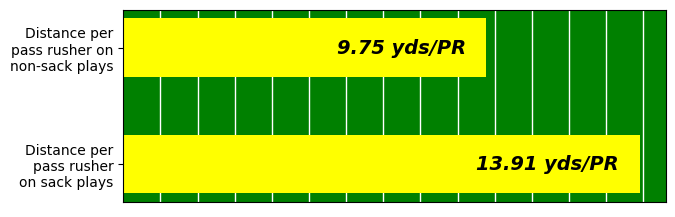

In [18]:
fig, ax = plt.subplots(figsize=(7, 2.5))
plt.barh(y=[0, 1], width=[sacks_dist_per_pr, nonsacks_dist_per_pr], height=0.5, color=['yellow'])
ax.set_yticks([0, 1], labels=['Distance per\npass rusher\non sack plays',
                              'Distance per\npass rusher on\nnon-sack plays'])
fd = {'fontstyle': 'italic', 'fontweight': 'bold', 'fontsize': 14}
plt.text(5.75, 0.95, f'{round(nonsacks_dist_per_pr, 2):,} yds/PR', fontdict=fd)
plt.text(9.5, -0.05, f'{round(sacks_dist_per_pr, 2):,} yds/PR', fontdict=fd)
ax.set_facecolor('green')
ax.set_xticks([])
for i in range(1, 15, 1):
    ax.axvline(i, color='white', lw=1, zorder=-1)
plt.show()

# Distribution of distances

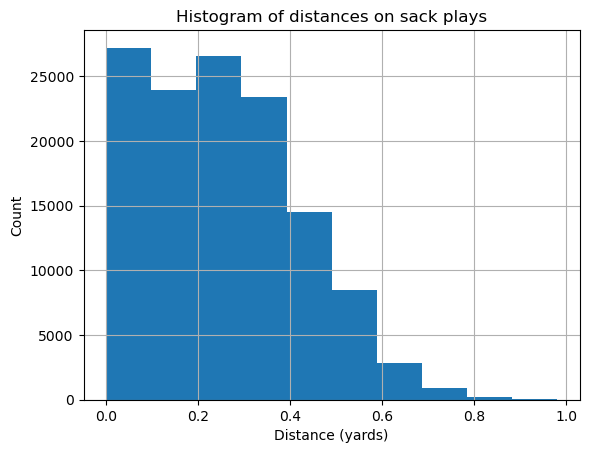

In [19]:
ax = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].hist()
ax.set_title('Histogram of distances on sack plays')
ax.set_xlabel('Distance (yards)')
ax.set_ylabel('Count')
plt.show()

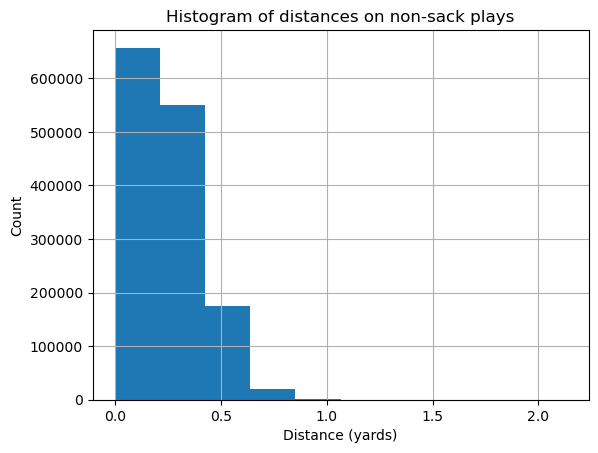

In [20]:
ax = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].hist()
ax.set_title('Histogram of distances on non-sack plays')
ax.set_xlabel('Distance (yards)')
ax.set_ylabel('Count')
plt.show()

In [21]:
nspr_df = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]
num_gt1yd = len(nspr_df.loc[nspr_df['dis'] > 1.0])
print('Number of non-sack plays with distance greater than 1 yard:', num_gt1yd)

Number of non-sack plays with distance greater than 1 yard: 15


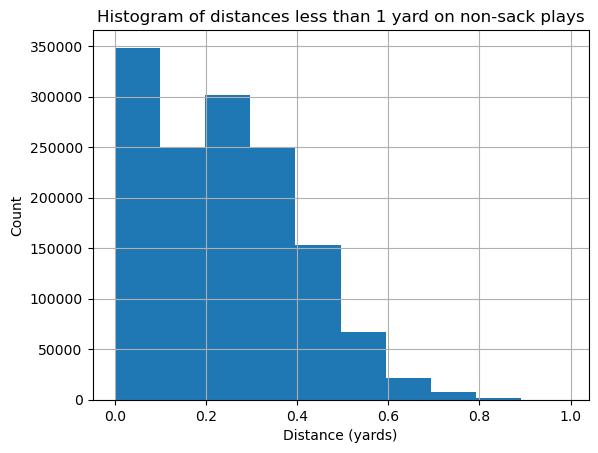

In [22]:
# Remove the long-tail outlier distances from non-sack plays
ax = nspr_df.loc[nspr_df['dis'] < 1.0]['dis'].hist()
ax.set_title('Histogram of distances less than 1 yard on non-sack plays')
ax.set_xlabel('Distance (yards)')
ax.set_ylabel('Count')
plt.show()

# Appendix

Some per-team charts to look at the number of pass plays and pass rushers faced.

In [23]:
TEAM_COLORS = {
    'ARI': '#97233f',
    'ATL': '#a71930',
    'BAL': '#241773',
    'BUF': '#00338d',
    'CAR': '#0085ca',
    'CHI': '#0b162a',
    'CIN': '#fb4f14',
    'CLE': '#fb4f14',
    'DAL': '#002244',
    'DEN': '#fb4f14',
    'DET': '#005a8b',
    'GB': '#203731',
    'HOU': '#a71930',
    'IND': '#002c5f',
    'JAX': '#006778',
    'KC': '#e31837',
    'LAC': '#0073cf',
    'LA': '#002244',
    'MIA': '#008e97',
    'MIN': '#4f2683',
    'NE': '#002244',
    'NO': '#9f8958',
    'NYG': '#0b2265',
    'NYJ': '#203731',
    'LV': '#a5acaf',
    'PHI': '#004953',
    'PIT': '#ffb612',
    'SF': '#aa0000',
    'SEA': '#69be28',
    'TB': '#d50a0a',
    'TEN': '#4b92db',
    'WAS': '#773141',    
}

In [24]:
# Count the number of plays per team
num_plays_per_team = {}
for t in track_df['team'].unique():
    if t != 'football':
        num_plays_per_team[t] = len(plays_df.loc[plays_df['possessionTeam'] == t])

num_plays_sorted = sorted(num_plays_per_team.items(), key=lambda x: x[1])

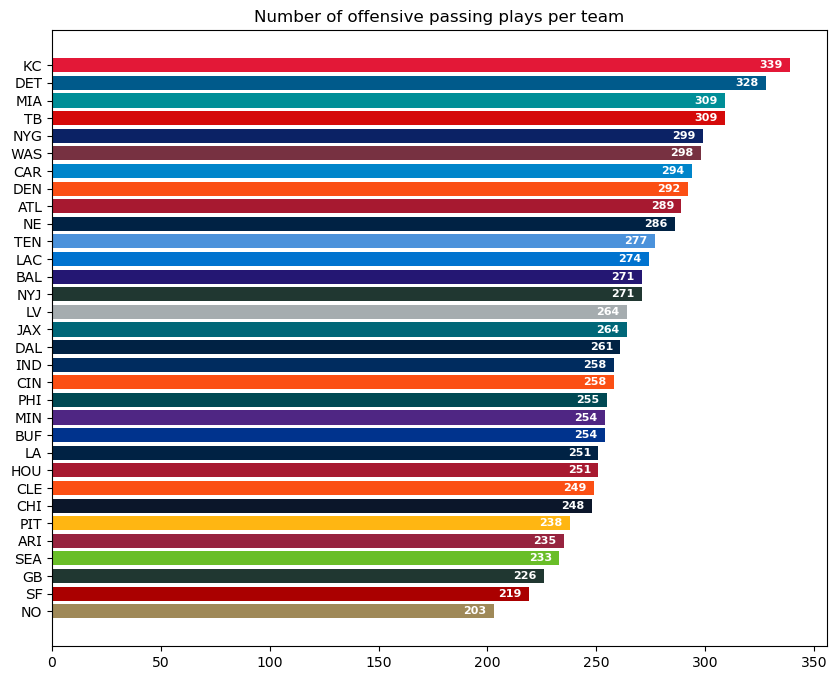

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = list(range(len(num_plays_sorted)))
axbars = ax.barh(y=y_pos,
                 width=[v[1] for v in num_plays_sorted],
                 align='center',
                 color=[TEAM_COLORS[t[0]] for t in num_plays_sorted],
                 height=0.8)
ax.bar_label(axbars, padding=-22, color='white', fontweight='bold', fontsize=8)
ax.set_yticks(y_pos, labels=[v[0] for v in num_plays_sorted], fontfamily='Verdana')
plt.title('Number of offensive passing plays per team')
plt.show()

In [26]:
# Count the number of pass rushers each team faced up against
num_pass_rushers_per_team = {}
for t in track_df['team'].unique():
    if t != 'football':
        plays_team_gb = plays_df.loc[plays_df['possessionTeam'] == t].groupby(['gameId', 'playId'])
        num_pass_rushers = len(scout_df.loc[(scout_gp_combos.isin(plays_team_gb.groups.keys())) & (scout_df['pff_role'] == 'Pass Rush')])
        num_pass_rushers_per_team[t] = num_pass_rushers

num_prs_sorted = sorted(num_pass_rushers_per_team.items(), key=lambda x: x[1])


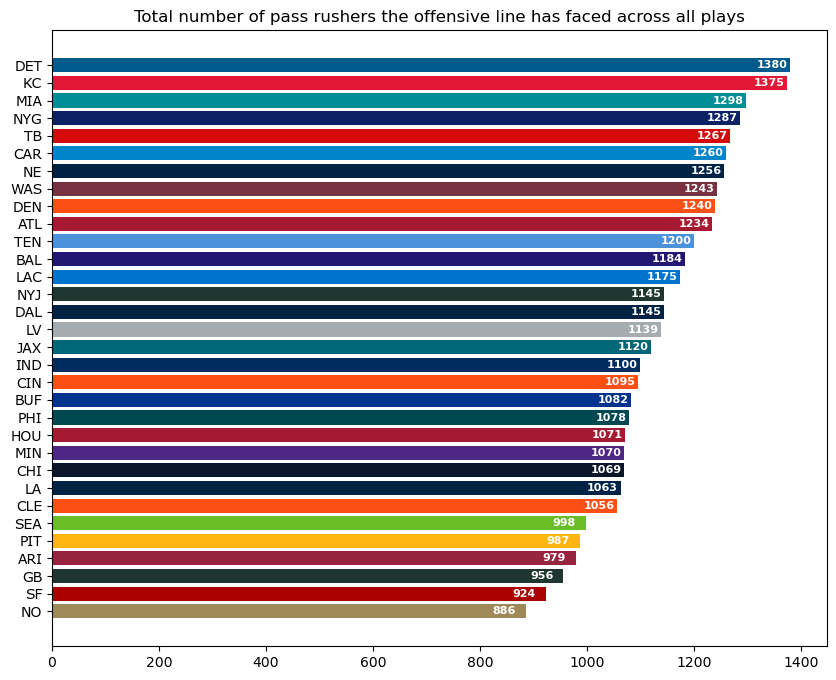

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = list(range(len(num_prs_sorted)))
axbars = ax.barh(y=y_pos,
                 width=[v[1] for v in num_prs_sorted],
                 align='center',
                 color=[TEAM_COLORS[t[0]] for t in num_prs_sorted],
                 height=0.8)
ax.bar_label(axbars, padding=-24, color='white', fontweight='bold', fontsize=8)
ax.set_yticks(y_pos, labels=[v[0] for v in num_prs_sorted], fontfamily='Verdana')
plt.title('Total number of pass rushers the offensive line has faced across all plays')
plt.show()